In [1]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha
import importlib
import bspline


cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

In [2]:
def fuck_knots(knots, degree):
    return numpy.concatenate((numpy.repeat(knots[0], degree), knots, numpy.repeat(knots[-1], degree)))

In [3]:
importlib.reload(bspline)

knots = numpy.linspace(-1000, 2000, 20)
times = numpy.linspace(-1000, 2000, 400)
base = bspline.deboor_base(fuck_knots(knots,3), times, 3)[:, :-4]

<IPython.core.display.Javascript object>


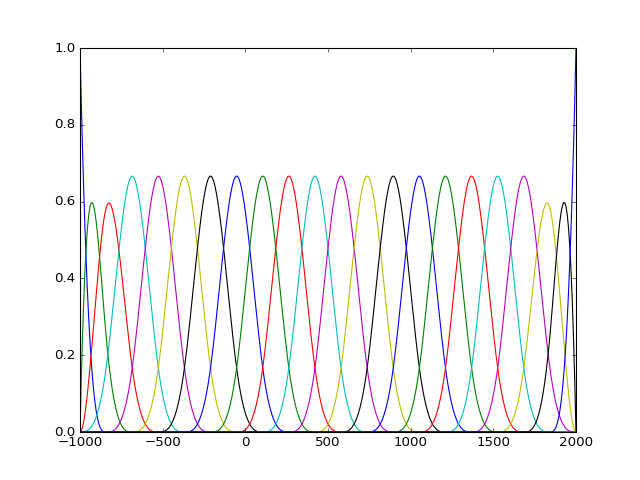

In [97]:
fig, ax = pyplot.subplots()

for b in base.T:
    ax.plot(times, b)
    
pyplot.show(fig)    

In [4]:
base.shape

(400, 22)

In [5]:
len(fuck_knots(knots,3)[:-4])

22

In [6]:
g=numpy.linspace(1, 30, 30)

In [7]:
g=numpy.tile(g, (12,1))

In [8]:
g.shape

(12, 30)

In [9]:
g.flatten()[0::30]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [10]:
base.shape

(400, 22)

In [24]:
theta_0 = numpy.deg2rad(50)
k, m, n = scha.join_roots(scha.degree(numpy.arange(0, 6), theta_0, max_k = 9))

In [12]:
n0, n1 = numpy.meshgrid(n, n, indexing="ij")
m0, m1 = numpy.abs(numpy.meshgrid(m, m, indexing="ij"))
k0, k1 = numpy.meshgrid(k, k, indexing="ij")

In [41]:
L = numpy.zeros_like(n0)

cond_0 = ((m0 == m1) & (numpy.mod(k0-m0, 2) == 0) & (numpy.mod(k1-m0, 2) != 0))
cond_1 = ((k0 == k1) & (m0 == m1) & (numpy.mod(k0-m0, 2) == 0))
cond_2 = ((k0 == k1) & (m0 == m1) & (numpy.mod(k0-m0, 2) != 0))

a = numpy.empty_like(m0)
a[m0 == 0] = 1/(1-cos(theta_0))
a[m0 != 0] = 0.5/(1-cos(theta_0))

pdp = scha.lpmv(m0, n0, cos(theta_0))*scha.dlpmv(m0, n1, cos(theta_0))*\
      scha.schmidt_real(m0, n0, grid=False)*scha.schmidt_real(m0, n1, grid=False)*(-sin(theta_0))
    
pdndp = scha.lpmv(m0, n0, cos(theta_0))*scha.dndlpmv(m0, n1, cos(theta_0))*\
        scha.schmidt_real(m0, n0, grid=False)*scha.schmidt_real(m0, n1, grid=False)*(-sin(theta_0))

dpdnp = scha.dlpmv(m0, n1, cos(theta_0))*scha.dnlpmv(m0, n0, cos(theta_0))*\
        scha.schmidt_real(m0, n0, grid=False)*scha.schmidt_real(m0, n1, grid=False)*(-sin(theta_0))

L[cond_0] = (1 - (n0[cond_0] + n1[cond_0] + 2)/(n1[cond_0] - n0[cond_0]))*a[cond_0]/2*sin(theta_0)*pdp[cond_0]
L[cond_1] = -(n0[cond_1] + 1)*a[cond_1]*sin(theta_0)*pdndp[cond_1]
L[cond_2] = (n0[cond_2]+1)*a[cond_2]*sin(theta_0)*dpdnp[cond_2]

In [42]:
L[cond_0]

array([  1.04468076,  -0.60492563,   0.46769013,  -0.39483747,
         0.34797645,   2.33280251,   2.33280251,  -1.17877445,
        -1.17877445,   0.87472671,   0.87472671,  -0.72367668,
        -0.72367668,   2.33280251,   2.33280251,  -1.17877445,
        -1.17877445,   0.87472671,   0.87472671,  -0.72367668,
        -0.72367668,   2.94315595,   3.92013955,  -1.69441983,
         1.19464315,  -0.9628584 ,   3.26306863,   3.26306863,
        -1.60036488,  -1.60036488,   1.17214796,   1.17214796,
        -0.96223858,  -0.96223858,   3.26306863,   3.26306863,
        -1.60036488,  -1.60036488,   1.17214796,   1.17214796,
        -0.96223858,  -0.96223858,   4.08753124,   4.08753124,
         5.12177764,   5.12177764,  -2.12596837,  -2.12596837,
         1.47133584,   1.47133584,   4.08753124,   4.08753124,
         5.12177764,   5.12177764,  -2.12596837,  -2.12596837,
         1.47133584,   1.47133584,   4.08638048,   4.08638048,
        -1.97943366,  -1.97943366,   1.44016507,   1.44

In [15]:
def dnlpmv(n, m, z, order=9):
    
    n = numpy.array(n)
    m = numpy.array(m)
    
    gamma = scipy.special.gamma
    digamma = scipy.special.digamma
    
    res = 0
    for k in range(1, order+1):
        res += gamma(k+n+1)/(gamma(k+1)*gamma(n-k+1)*gamma(k-m+1))*(digamma(k+n+1)-digamma(n-k+1))* \
        ((z-1)/2)**k
    res = res*((z+1)/(z-1))**m/2
    return res

In [16]:
def dnlpmv_num(n, m, z, delta=0.00001):
    n = numpy.array(n)
    m = numpy.array(m)
    
    #add normalization?
    return (scha.lpmv(m, n+delta, z)-scha.lpmv(m, n-delta, z))/(2*delta)

In [17]:
dnlpmv(n, m, cos(theta_0), order=25)

array([ -9.83763098e-02,  -2.40371450e-01,   5.85461264e-01,
         3.40153647e-02,   6.44904452e-03,  -1.77945016e+00,
         2.00557806e-02,   8.38045533e+00,  -2.73783493e-03,
         1.58282414e-01,  -3.43811531e-01,  -2.60068299e-03,
        -2.57640013e+01,  -1.01159791e-03,   1.67893685e+02,
         1.36557693e-04,  -2.65408285e-03,   2.41504468e+00,
        -8.12354597e-03,  -1.11821575e+01,   1.71211721e-04,
        -5.54904022e+02,   3.70182544e-05,   4.44651925e+03,
        -4.99586122e-06,  -1.26358229e-01,   2.71127388e-01,
         8.04087272e-04,   5.45230973e+01,   2.97400698e-04,
        -3.79321721e+02,  -6.98186882e-06,  -1.58569680e+04,
        -1.06776800e-06,   1.47246229e+05,   1.44926139e-07,
         1.52670362e-03,  -2.91042378e+00,   4.65601539e-03,
         1.34079569e+01,  -4.23326566e-05,   1.62745874e+03,
        -8.51113004e-06,  -1.48922832e+04,   2.12399608e-07,
        -5.64413890e+05,   2.54748304e-08,   5.86315447e+06,
        -3.48995375e-09,

In [123]:
gamma = scipy.special.gamma
digamma = scipy.special.digamma
factorial = scipy.special.factorial

In [124]:
gamma(4+3+1)/(factorial(4)*gamma(3-4+1))

0.0

<IPython.core.display.Javascript object>


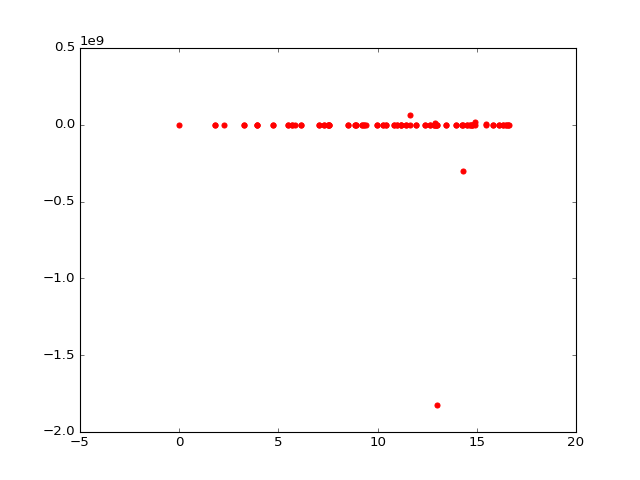

In [156]:
fig, ax = pyplot.subplots()

#ax.plot(nn, numpy.gradient(scha.lpmv(0, nn, cos(theta_0)), 0.1))
#ax.plot(nn, scha.lpmv(0, nn, cos(theta_0)))
#ax.scatter(n, dnlpmv(n, m, cos(theta_0), order=25))
ax.scatter(n, dnlpmv_num(n, m, cos(theta_0)), color="red")

In [103]:
scha.lpmv(0, nn, cos(theta_0))

array([], dtype=float64)

In [241]:
bug = numpy.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

In [255]:
S.shape

(50, 50)

In [260]:
n_knots = S.shape[0]
n_degrees = L.shape[0]

R = numpy.tile(L.toarray(), (n_knots, n_knots)) + numpy.repeat(numpy.repeat(S, n_degrees, axis=0), n_degrees, axis=1)

In [49]:
importlib.reload(scha)
L = scha.spatial_reg(k, m, n, theta_0).toarray()

In [53]:
L[(L < 0) & cond_0]

array([ -6.04925626e-01,  -3.94837473e-01,  -1.17877445e+00,
        -7.23676682e-01,  -3.67359791e-03,  -6.25388990e-04,
        -1.69441983e+00,  -9.62858403e-01,  -1.60036488e+00,
        -9.62238579e-01,  -1.10017613e-06,  -6.93530878e-08,
        -2.12596837e+00,  -4.14844778e-04,  -1.97943366e+00,
        -7.19648547e-11,  -1.20622697e+00,  -2.58076814e+00,
        -2.52322678e+00,  -2.26458759e-08,  -2.33164452e+00,
        -1.61160611e-15,  -1.61255082e+00,  -3.00204937e+00,
        -8.70155771e-04,  -1.34064225e-04,  -2.89663781e+00,
        -4.28579165e-13,  -2.66409250e+00,  -1.56815217e-20,
        -2.13333772e+00,  -3.44637402e+00,  -1.93679970e+00,
        -3.39920339e+00,  -9.37970503e-08,  -2.39766392e-09,
        -3.25176546e+00,  -3.55661650e-18,  -2.98094045e+00,
        -7.70157364e-26,  -2.54400480e+00,  -2.18264518e-04,
        -2.22346185e+00,  -2.95846687e-12,  -6.86304531e-01,
        -3.01694868e+00,  -2.90506245e+00,  -6.43558740e-09,
        -2.48719804e+00,

In [4]:
knots = numpy.linspace(-1000, 2000, 20)

In [21]:
Rt = 6371.2
    
n_knots = len(knots)
n_degrees = len(k)
S = numpy.diff(numpy.eye(n_knots),2,axis=0)

S_sq = S.T @ S
    
n0, n1 = numpy.meshgrid(n, n, indexing="ij")
m0, m1 = numpy.meshgrid(m, m, indexing="ij")
k0, k1 = numpy.meshgrid(k, k, indexing="ij")

L = numpy.zeros_like(n0)

c_0 = ((m0 == m1) & (numpy.mod(k0 - m0, 2) == 0) & (numpy.mod(k1-m0, 2) != 0))
c_1 = ((k0 == k1) & (m0 == m1) & (numpy.mod(k0 - m0, 2) == 0))
c_2 = ((k0 == k1) & (m0 == m1) & (numpy.mod(k0 - m0, 2) != 0))

# factor misterioso, ver korte 2003
a = numpy.empty_like(m0)
a[m0 == 0] = 1/(1-cos(theta_0))
a[m0 != 0] = 0.5/(1-cos(theta_0))

#squared normalization
square_sch = scha.schmidt_real(m0, n0, grid=False)*scha.schmidt_real(m1, n1, grid=False)
    
#legendre poly * derivative (* chain rule)
pdp = scha.lpmv(m0, n0, cos(theta_0))*scha.dlpmv(m1, n1, cos(theta_0))*square_sch*(-sin(theta_0))
pdndp = scha.lpmv(m0, n0, cos(theta_0))*scha.dndlpmv(m1, n1, cos(theta_0))*square_sch*(-sin(theta_0))
dpdnp = scha.dlpmv(m1, n1, cos(theta_0))*scha.dnlpmv(m0, n0, cos(theta_0))*square_sch*(-sin(theta_0))
dpp = scha.dlpmv(m0, n0, cos(theta_0))*square_sch*(-sin(theta_0))*scha.lpmv(m1, n1, cos(theta_0))

F = numpy.zeros((n_degrees, n_degrees))

F[c_0] = -sin(theta_0)/((n0[c_0]-n1[c_0])*(n0[c_0]+n1[c_0]+1))*dpp[c_0] 
F[c_1] = -sin(theta_0)/(2*n0[c_1]+1)*pdndp[c_1]
F[c_2] = sin(theta_0)/(2*n0[c_2]+1)*dpdnp[c_2]

L = (n0+1)*(n1+1)*a*F

S_sq = numpy.repeat(numpy.repeat(S_sq, n_degrees, axis=0), n_degrees, axis=1)
L_sq = numpy.tile(L, (n_knots, n_knots))
    
super_magia = S_sq * L_sq

<IPython.core.display.Javascript object>


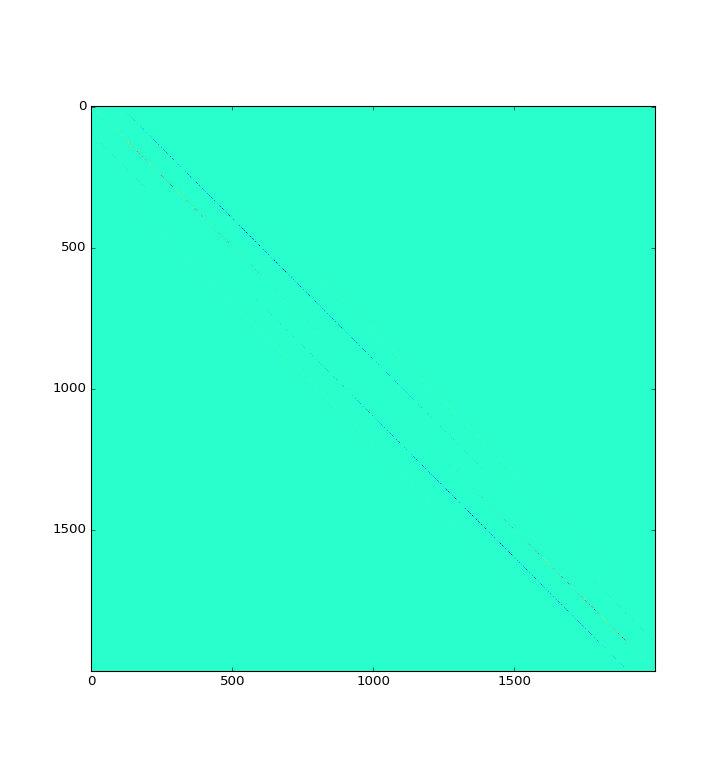

In [30]:
fig, ax = pyplot.subplots()

ax.imshow(super_magia)

In [5]:
importlib.reload(scha)

<module 'scha' from '/home/josecper/Programs/python/scha.py'>

In [25]:
super_magia=scha.time_reg(k,m,n,knots, theta_0)

In [27]:
numpy.sum(numpy.isnan(super_magia))

0

In [64]:
-sin(theta_0)/(2*0 + 1)*(scha.lpmv(0,0,cos(theta_0))*scha.schmidt_real(0,0)**2*scha.dndlpmv(0,0,cos(theta_0))*(-sin(theta_0)))

0.99999999998127165

In [7]:
super_magia.shape

(2000, 2000)

In [29]:
numpy.sum(numpy.isnan(scha.time_reg(k, m, n, knots, numpy.pi-0.01)))

0

In [11]:
len(knots)

20

*** el error es que cuando usas grados enteros la regularización del tiempo regional (la de d²Br²/dt²) peta ***

In [ ]:
numpy.sum(numpy.isnan(scha.time_reg(k, m, n, knots, numpy.pi-0.01)))